**About the Project**

Build a machine learning model that can recommend products to users based on their past behaviour and preferences

**About the Dataset**

The dataset attributes:

Total Records: 568454 consumer reviews on different amazon products
Total Columns: 10
Domain Name: amazon.com 
File Extension: CSV

Available Fields: Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenomenator, Score, Time, Summary, Text

**Import the necessary libraries**

In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy

from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from wordcloud import WordCloud
#TfidfVectorizer and CountVectorizer used in converting text data into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

**Loading the dataset**

In [2]:
df = pd.read_csv('/kaggle/input/amazon-product-reviews/Reviews.csv')

In [4]:
#check the first five rows of the dataset
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
#choose some needed columns of the dataset
df  = df[['ProductId','Score','Summary','Text']]

In [6]:
df.head()

,ProductId,Score,Summary,Text
0,B001E4KFG0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,2,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,5,Great taffy,Great taffy at a great price. There was a wid...


In [13]:
#check the number of columns and rows
df.shape

(568454, 4)

In [7]:
#choose the first 20,000 rows and all the columns
df = df.iloc[:20000,:]

In [17]:
#check the number of rows and columns
df.shape

(20000, 4)

In [18]:
#check the missing values
df.isnull().sum()

ProductId    0
Score        0
Summary      0
Text         0
dtype: int64

In [8]:
#check for the duplicated values
df.duplicated().sum()

22

In [10]:
#drop the duplicated values
df.drop_duplicates(inplace=True)

In [11]:
df.duplicated().sum()

0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19978 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProductId  19978 non-null  object
 1   Score      19978 non-null  int64 
 2   Summary    19978 non-null  object
 3   Text       19978 non-null  object
dtypes: int64(1), object(3)
memory usage: 780.4+ KB


In [15]:
df.describe()

,Score
count,19978.000000
mean,4.160777
std,1.315016
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


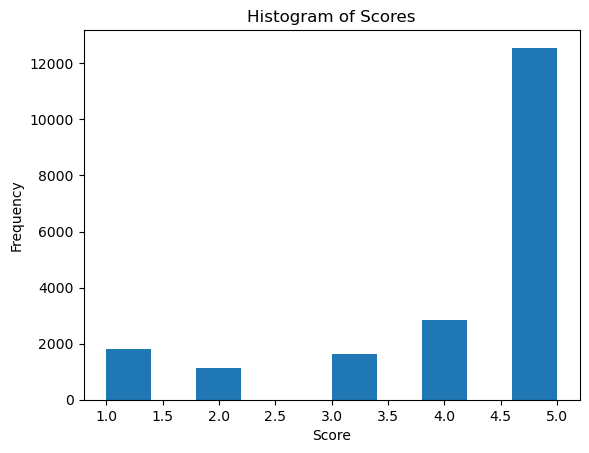

In [16]:
# Create a histogram of the Score column
df["Score"].plot(kind="hist")

plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Histogram of Scores")

plt.show()

In [17]:
# Group the data by ProductId and calculate the average score for each product
product_scores = df.groupby("ProductId")["Score"].mean()

# Display the result
print(product_scores)

ProductId
B00002NCJC    4.5
B00002Z754    5.0
B00005V3DC    5.0
B000084DVR    5.0
B000084E1U    5.0
             ... 
B009D668KS    5.0
B009HINRX8    4.5
B009KP6HBM    4.0
B009UOFU20    1.0
B009WSNWC4    5.0
Name: Score, Length: 2657, dtype: float64


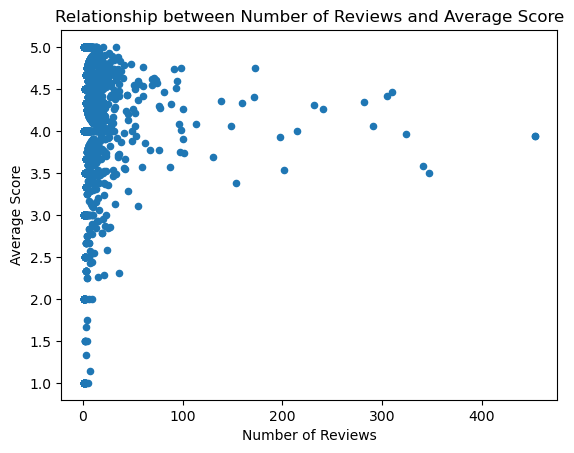

In [19]:
# Group the data by ProductId and calculate the average score and number of reviews for each product
product_data = df.groupby("ProductId").agg({"Score": "mean", "Text": "count"})

# Create a scatter plot of the data
product_data.plot(kind="scatter", x="Text", y="Score")

plt.xlabel("Number of Reviews")
plt.ylabel("Average Score")
plt.title("Relationship between Number of Reviews and Average Score")

plt.show()

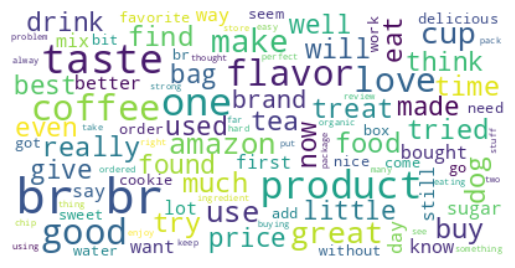

In [12]:
# Preprocess data
text = ' '.join(df['Text'].astype(str).tolist())
text = text.lower()

# Generate word cloud
wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=40).generate(text)

# Display word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/tmp/ipykernel_32/3630689693.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]', '')


    00  002  0035ounce  005  009   01  010  0107  012  016br  ...  zuchon  \
0  0.0  0.0        0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...     0.0   
1  0.0  0.0        0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...     0.0   
2  0.0  0.0        0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...     0.0   
3  0.0  0.0        0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...     0.0   
4  0.0  0.0        0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  ...     0.0   

   zuke  zukebr  zukes  zukess  zupas  zuppa  zwieback  çaykur  îts  
0   0.0     0.0    0.0     0.0    0.0    0.0       0.0     0.0  0.0  
1   0.0     0.0    0.0     0.0    0.0    0.0       0.0     0.0  0.0  
2   0.0     0.0    0.0     0.0    0.0    0.0       0.0     0.0  0.0  
3   0.0     0.0    0.0     0.0    0.0    0.0       0.0     0.0  0.0  
4   0.0     0.0    0.0     0.0    0.0    0.0       0.0     0.0  0.0  

[5 rows x 37699 columns]


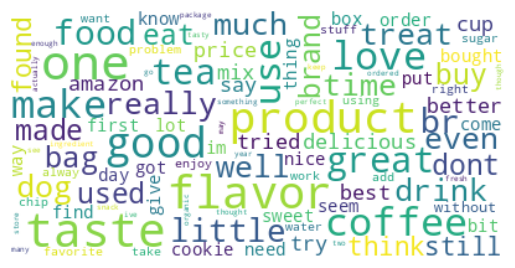

In [13]:
#Preprocess text data
df['Text'] = df['Text'].str.lower()
df['Text'] = df['Text'].str.replace('[^\w\s]', '')

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Perform word frequency analysis
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['Text'])
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(tfidf_df.head())

# Generate word cloud
text = ' '.join(df['Text'].tolist())
wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=40).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

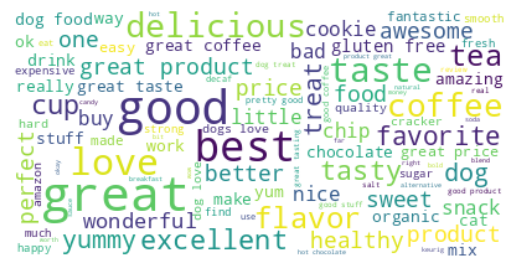

In [14]:
# Preprocess data
text = ' '.join(df['Summary'].astype(str).tolist())
text = text.lower()

# Generate word cloud
wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=40).generate(text)

# Display word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/tmp/ipykernel_32/2038761453.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Summary'] = df['Summary'].str.replace('[^\w\s]', '')


    08  081fl  088can   10  100  100calorie  100count  102012  103  105  ...  \
0  0.0    0.0     0.0  0.0  0.0         0.0       0.0     0.0  0.0  0.0  ...   
1  0.0    0.0     0.0  0.0  0.0         0.0       0.0     0.0  0.0  0.0  ...   
2  0.0    0.0     0.0  0.0  0.0         0.0       0.0     0.0  0.0  0.0  ...   
3  0.0    0.0     0.0  0.0  0.0         0.0       0.0     0.0  0.0  0.0  ...   
4  0.0    0.0     0.0  0.0  0.0         0.0       0.0     0.0  0.0  0.0  ...   

   zero  zest  zesty  zing  zippy  ziwipeak  zoes  zots  zqueen  zukes  
0   0.0   0.0    0.0   0.0    0.0       0.0   0.0   0.0     0.0    0.0  
1   0.0   0.0    0.0   0.0    0.0       0.0   0.0   0.0     0.0    0.0  
2   0.0   0.0    0.0   0.0    0.0       0.0   0.0   0.0     0.0    0.0  
3   0.0   0.0    0.0   0.0    0.0       0.0   0.0   0.0     0.0    0.0  
4   0.0   0.0    0.0   0.0    0.0       0.0   0.0   0.0     0.0    0.0  

[5 rows x 7164 columns]


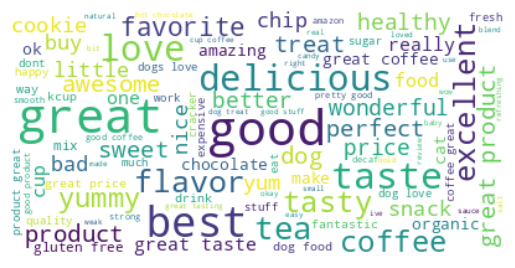

In [15]:
#Preprocess text data
df['Summary'] = df['Summary'].str.lower()
df['Summary'] = df['Summary'].str.replace('[^\w\s]', '')

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['Summary'] = df['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Perform word frequency analysis
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['Summary'])
feature_names = tfidf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(tfidf_df.head())

# Generate word cloud
text = ' '.join(df['Summary'].tolist())
wordcloud = WordCloud(background_color='white', max_words=100, max_font_size=40).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

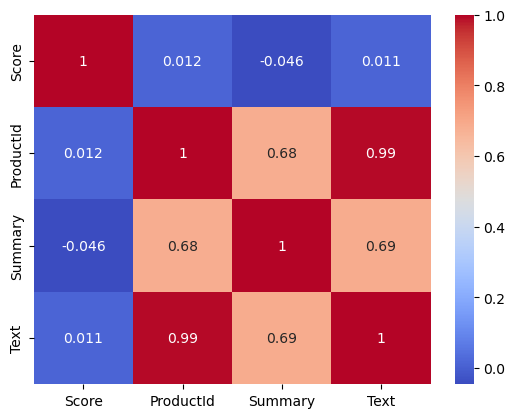

In [28]:
#used factorize instead of using an encoding
df['ProductId'] = pd.factorize(df['ProductId'])[0]
df['Summary'] = pd.factorize(df['Summary'])[0]
df['Text'] = pd.factorize(df['Text'])[0]

# Compute the correlation matrix
corr_matrix = df[['Score', 'ProductId', 'Summary', 'Text']].corr()

#Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#Display the plot
plt.show()

In [16]:
# number of characters in Text
df['Chars_Text']=df['Text'].apply(len)
# number of words in Text
#word_tokenize tokenizes text into words
df['Words_Text']=df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))
# number of sentences in Text
df['Sentences_Text']=df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [17]:
df.head()

,ProductId,Score,Summary,Text,Chars_Text,Words_Text,Sentences_Text
0,B001E4KFG0,5,good quality dog food,bought several vitality canned dog food produc...,164,23,1
1,B00813GRG4,1,advertised,product arrived labeled jumbo salted peanutsth...,136,18,1
2,B000LQOCH0,4,delight says,confection around centuries light pillowy citr...,285,40,1
3,B000UA0QIQ,2,cough medicine,looking secret ingredient robitussin believe f...,128,18,1
4,B006K2ZZ7K,5,great taffy,great taffy great price wide assortment yummy ...,83,13,1


In [18]:
# number of characters in Summary
df['Chars_Summary']=df['Summary'].apply(len)
# number of words in Summary
#word_tokenize tokenizes text into words
df['Words_Summary']=df['Summary'].apply(lambda x:len(nltk.word_tokenize(x)))
# number of sentences in Summary
df['Sentences_Summary']=df['Summary'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [19]:
df.head()

,ProductId,Score,Summary,Text,Chars_Text,Words_Text,Sentences_Text,Chars_Summary,Words_Summary,Sentences_Summary
0,B001E4KFG0,5,good quality dog food,bought several vitality canned dog food produc...,164,23,1,21,4,1
1,B00813GRG4,1,advertised,product arrived labeled jumbo salted peanutsth...,136,18,1,10,1,1
2,B000LQOCH0,4,delight says,confection around centuries light pillowy citr...,285,40,1,12,2,1
3,B000UA0QIQ,2,cough medicine,looking secret ingredient robitussin believe f...,128,18,1,14,2,1
4,B006K2ZZ7K,5,great taffy,great taffy great price wide assortment yummy ...,83,13,1,11,2,1


In [21]:
df[["Chars_Text","Words_Text","Sentences_Text"]].describe()

,Chars_Text,Words_Text,Sentences_Text
count,19978.000000,19978.000000,19978.0
mean,267.540094,40.695916,1.0
std,272.080833,40.280806,0.0
min,21.000000,4.000000,1.0
25%,111.000000,17.000000,1.0
50%,186.000000,28.000000,1.0
75%,325.000000,50.000000,1.0
max,7008.000000,969.000000,1.0


In [22]:
df[["Chars_Summary","Words_Summary","Sentences_Summary"]].describe()

,Chars_Summary,Words_Summary,Sentences_Summary
count,19978.000000,19978.000000,19978.000000
mean,18.073931,2.892282,0.997998
std,10.751718,1.611458,0.044702
min,0.000000,0.000000,0.000000
25%,10.000000,2.000000,1.000000
50%,16.000000,3.000000,1.000000
75%,24.000000,4.000000,1.000000
max,114.000000,17.000000,1.000000


In [25]:
!pip install nltk

In [26]:
!python -m spacy download en_core_web_sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [32]:
!pip install spacy

In [20]:
#imports the spaCy library and loads the English language model called "en_core_web_sm"
nlp = spacy.load("en_core_web_sm")
#function to lematize the words
def limit(word):
    obj=nlp(word)
    for token in obj:
        #returns the base form of the token
        return token.lemma_

In [23]:
#function for the text preprocessing
def process(text):
    import string
    text=text.lower()
    text=nltk.word_tokenize(text)
    #limit the word if it is only within the stopwords
    text=[limit(word) for word in text if word not in nltk.corpus.stopwords.words('english')]
    #tokenize it if the word is not a punctation mark
    text=[word for word in text if word not in string.punctuation]
    #tokenize it if the word is a number(alphanumeric)
    text=[word for word in text if word.isalnum()]
    text=' '.join(text)
    return text

In [24]:
#a new column for the converted, preprocessed text (to be more easier in modelling)
df['Converted_Text']=df['Text'].apply(process)

In [25]:
df.head()

,ProductId,Score,Summary,Text,Chars_Text,Words_Text,Sentences_Text,Chars_Summary,Words_Summary,Sentences_Summary,Converted_Text
0,B001E4KFG0,5,good quality dog food,bought several vitality canned dog food produc...,164,23,1,21,4,1,buy several vitality can dog food product find...
1,B00813GRG4,1,advertised,product arrived labeled jumbo salted peanutsth...,136,18,1,10,1,1,product arrive label jumbo salt peanutsthe pea...
2,B000LQOCH0,4,delight says,confection around centuries light pillowy citr...,285,40,1,12,2,1,confection around century light pillowy citru ...
3,B000UA0QIQ,2,cough medicine,looking secret ingredient robitussin believe f...,128,18,1,14,2,1,look secret ingredient robitussin believe find...
4,B006K2ZZ7K,5,great taffy,great taffy great price wide assortment yummy ...,83,13,1,11,2,1,great taffy great price wide assortment yummy ...


In [26]:
#a new column for the converted, preprocessed summary (to be more easier in modelling)
df['Converted_Summary']=df['Summary'].apply(process)

In [27]:
df.head()

,ProductId,Score,Summary,Text,Chars_Text,Words_Text,Sentences_Text,Chars_Summary,Words_Summary,Sentences_Summary,Converted_Text,Converted_Summary
0,B001E4KFG0,5,good quality dog food,bought several vitality canned dog food produc...,164,23,1,21,4,1,buy several vitality can dog food product find...,good quality dog food
1,B00813GRG4,1,advertised,product arrived labeled jumbo salted peanutsth...,136,18,1,10,1,1,product arrive label jumbo salt peanutsthe pea...,advertise
2,B000LQOCH0,4,delight says,confection around centuries light pillowy citr...,285,40,1,12,2,1,confection around century light pillowy citru ...,delight say
3,B000UA0QIQ,2,cough medicine,looking secret ingredient robitussin believe f...,128,18,1,14,2,1,look secret ingredient robitussin believe find...,cough medicine
4,B006K2ZZ7K,5,great taffy,great taffy great price wide assortment yummy ...,83,13,1,11,2,1,great taffy great price wide assortment yummy ...,great taffy


In [28]:
#used to convert the text data into a matrix of token counts
cv=CountVectorizer()
#Iconverts the text data into a matrix representation(each row represents a document (message) and each column represents a unique word in the corpus)
X=cv.fit_transform(df['Converted_Text']).toarray()
y=df['ProductId'].values

In [29]:
#Used to convert the text data into a matrix of token counts
cv=CountVectorizer()
#Iconverts the text data into a matrix representation(each row represents a document (message) and each column represents a unique word in the corpus)
X=cv.fit_transform(df['Converted_Summary']).toarray()
y=df['ProductId'].values

Apply K_means clustering algorithm

In [30]:
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Define a function to perform K-means clustering
def kmeans_clustering(tfidf_matrix, num_clusters):
    # Initialize the K-means clustering algorithm
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)

    # Fit the data to the K-means algorithm
    kmeans.fit(tfidf_matrix)

    # Get the cluster labels for each data point
    cluster_labels = kmeans.labels_

    return cluster_labels

In [31]:
# Define a function to get top N recommendations for a user based on clusters
def get_top_n_recommendations_cluster(ProductId, df, cluster_labels, cosine_sim, n=5):
    # Get the indices of the user's reviews
    user_reviews_index = df[df['ProductId'] == ProductId].index

    # Get the cluster label for the user's reviews
    user_cluster_label = cluster_labels[user_reviews_index]

    # Get the indices of the data points in the same cluster as the user
    cluster_indices = np.where(cluster_labels == user_cluster_label)[0]

    # Compute the average cosine similarity score for the user's cluster
    cluster_avg_cosine_sim = cosine_sim[cluster_indices].mean(axis=0)

    # Get the indices of the top N products based on cosine similarity within the cluster
    top_n_indices = cluster_avg_cosine_sim.argsort()[::-1][:n]

    # Get the corresponding product IDs
    top_n_product_ids = df.iloc[top_n_indices]['ProductId'].values

    return top_n_product_ids

In [39]:
# Test the function with a sample user ID
ProductId = 'A3OXHLG6DIBRW8'
num_clusters = 5

# Perform K-means clustering
cluster_labels = kmeans_clustering(tfidf_matrix, num_clusters)

# Get top N recommendations based on clusters
top_n_recommendations = get_top_n_recommendations_cluster(ProductId, df, cluster_labels, cosine_sim, n=6)
print(f"Top 6 recommendations for {ProductId}: {top_n_recommendations}")

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Top 6 recommendations for A3OXHLG6DIBRW8: ['B002C50X1M' 'B001LG945O' 'B001LG945O' 'B001LG945O' 'B001LG945O'
 'B001LG945O']


/tmp/ipykernel_32/3513834092.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  cluster_indices = np.where(cluster_labels == user_cluster_label)[0]
/tmp/ipykernel_32/3513834092.py:13: RuntimeWarning: Mean of empty slice.
  cluster_avg_cosine_sim = cosine_sim[cluster_indices].mean(axis=0)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
